In [1]:
# useful imports
import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

cols = [c['color'] for c in matplotlib.rcParams['axes.prop_cycle']]

/home/aboustati/miniconda3/envs/gpflow-v1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# GPflow imports
import gpflow

from gpflow.likelihoods import Gaussian, SwitchedLikelihood
from gpflow.kernels import Matern52, RBF, White
from gpflow.mean_functions import Linear

In [3]:
# dgplib imports
from dgplib.layers import InputLayer, OutputLayer, HiddenLayer
from dgplib.multikernel_layers import MultikernelInputLayer, MultikernelOutputLayer
from dgplib.models import MultitaskSequential
from dgplib.specialized_kernels import SwitchedKernel

from dgplib.multitask_dsdgp import MultitaskDSDGP

In [4]:
Ns = 300
Xs = np.linspace(-12, 12, Ns)[:, None]
Ys1 = np.sinc(Xs)
Ys2 = np.sinc(Xs) + np.sinc(5-Xs) + np.sinc(5+Xs)
Xs_augmented = np.vstack((np.hstack((Xs, np.zeros_like(Xs))), np.hstack((Xs, np.ones_like(Xs)))))

N1, N2, M = 150, 100, 50
X1 = np.random.uniform(-10, 10, N1)[:, None]
X2 = np.random.uniform(-10, 10, N2)[:,None]
X2 = X2[np.logical_or((X2<-3), (X2>3))][:,None]
Z = np.random.uniform(-10, 10, M)[:, None]
Y1 = np.sinc(X1) + np.random.randn(*X1.shape)*1e-2
Y2 = np.sinc(X2) + np.sinc(5-X2) + np.sinc(5+X2) + np.random.randn(*X2.shape)*1e-2

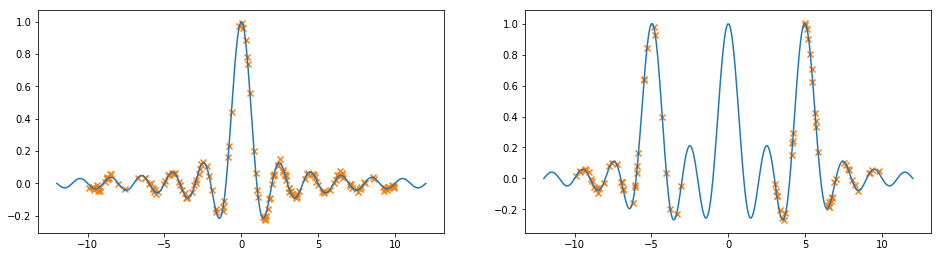

In [5]:
plt.figure(figsize=(16,9))
plt.subplot(221)
plt.plot(Xs, Ys1)
plt.scatter(X1, Y1, c=cols[1], marker='x')

plt.subplot(222)
plt.plot(Xs, Ys2)
plt.scatter(X2, Y2, c=cols[1], marker='x')

In [6]:
Z_augmented = np.vstack((np.hstack((Z, np.zeros_like(Z))), np.hstack((Z, np.ones_like(Z)))))
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

In [7]:
# Layers
input_kernels = [RBF(1, lengthscales=0.8, variance=1.)+White(1, variance=1e-5),
                 RBF(1, lengthscales=0.2, variance=2.1)+White(1, variance=1e-5)]
input_layer = MultikernelInputLayer(input_dim=1,
                         output_dim=2, 
                         num_inducing=2*M, 
                         kernel_list=input_kernels, 
                         mean_function=Linear(A=np.zeros((2,2))),
                         multitask=True)

input_layer.q_sqrt = input_layer.q_sqrt.value * 1e-5

kern_list = [RBF(1, lengthscales=1.3, variance=1.)+White(1, variance=1e-5),
             RBF(1, lengthscales=1.4, variance=1.1)+White(1, variance=1e-5)]

output_layer = OutputLayer(input_dim=2, 
                           output_dim=1, 
                           num_inducing=2*M,
                           kernel=SwitchedKernel(kern_list, 2),
                           multitask=True)

In [8]:
seq = MultitaskSequential([input_layer, output_layer])

In [9]:
lik = SwitchedLikelihood([Gaussian(), Gaussian()])

In [10]:
model = MultitaskDSDGP(X=X_augmented, Y=Y_augmented, Z=Z_augmented, layers=seq, likelihood=lik, num_latent_Y=1)

[[1. 0.]
 [0. 0.]]
(2, 2)
Model Parameters Initialized


In [11]:
print(model)

                                                        class prior transform  \
MultitaskDSDGP/layers/layers/0/kernel/0/rbf/var...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/kernel/0/rbf/len...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/kernel/0/white/v...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/kernel/1/rbf/var...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/kernel/1/rbf/len...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/kernel/1/white/v...  Parameter  None       +ve   
MultitaskDSDGP/layers/layers/0/mean_function/A      Parameter  None    (none)   
MultitaskDSDGP/layers/layers/0/mean_function/b      Parameter  None    (none)   
MultitaskDSDGP/layers/layers/0/q_mu                 Parameter  None    (none)   
MultitaskDSDGP/layers/layers/0/q_sqrt               Parameter  None    (none)   
MultitaskDSDGP/layers/layers/0/Z/0                  Parameter  None    (none)   
MultitaskDSDGP/layers/layers

In [12]:
model.compile()

In [13]:
model.compute_log_likelihood()

-2542.5719769461843

In [14]:
opt = gpflow.train.AdamOptimizer(0.01)
opt.minimize(model, maxiter=1000)

/home/aboustati/miniconda3/envs/gpflow-v1/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
model.compute_log_likelihood()

70.1612154856445

/home/aboustati/miniconda3/envs/gpflow-v1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


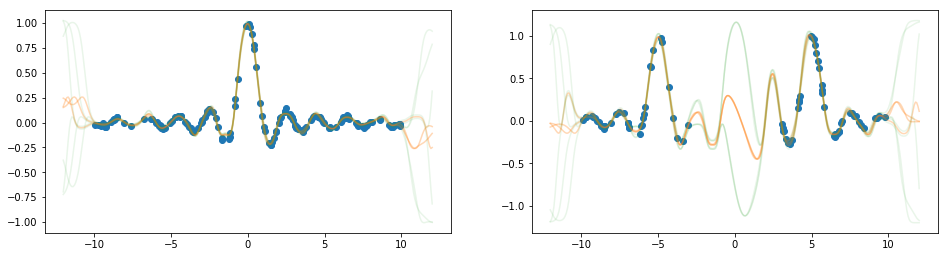

In [16]:
plt.figure(figsize=(16,9))
for _ in range(3):
    samples = model.predict_f_full_cov(Xs_augmented, 1)
    sigma = np.diag(samples[1][0,:,:,0])
    plt.subplot(221)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].reshape((Ns,)), color=cols[1], alpha=0.3)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].reshape((Ns,))+2*np.sqrt(sigma)[:Ns], color=cols[2], alpha=0.1)
    plt.plot(Xs_augmented[:Ns,0], samples[0][:,:Ns,0].reshape((Ns,))-2*np.sqrt(sigma)[:Ns], color=cols[2], alpha=0.1)
    plt.subplot(222)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].reshape((Ns,)), color=cols[1], alpha=0.3)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].reshape((Ns,))+2*np.sqrt(sigma)[Ns:], color=cols[2], alpha=0.1)
    plt.plot(Xs_augmented[Ns:,0], samples[0][:,Ns:,0].reshape((Ns,))-2*np.sqrt(sigma)[Ns:], color=cols[2], alpha=0.1)

#plt.title('2 layer DGP')
plt.subplot(221)
plt.scatter(X1, Y1)
plt.subplot(222)
plt.scatter(X2, Y2)
plt.show()

/home/aboustati/miniconda3/envs/gpflow-v1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


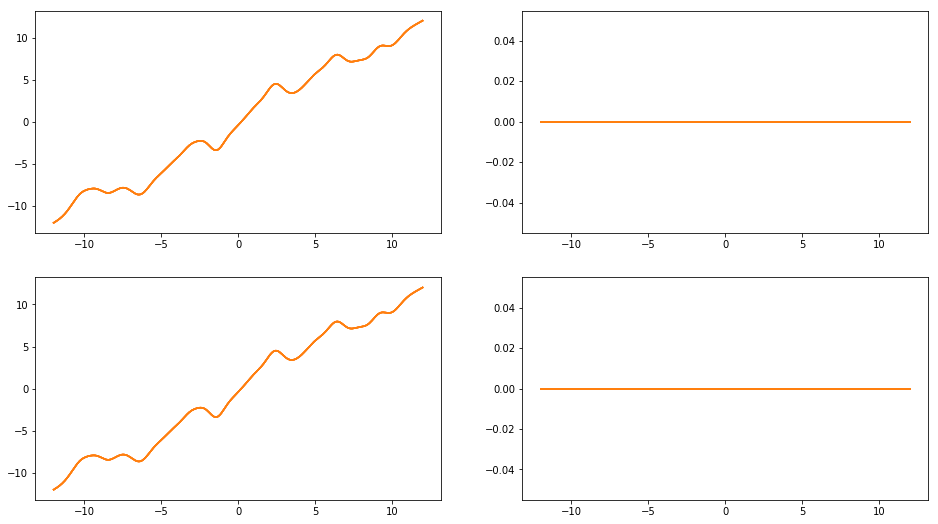

In [17]:
plt.figure(figsize=(16,9))
for _ in range(20):
    samples = model.predict_all_layers_full_cov(Xs_augmented, 1)
    for i in range(2):
        s = samples[1][0][0,:,i]
        plt.subplot(2, 2, i+1)
        plt.plot(Xs_augmented[:Ns,0], s[:Ns], color=cols[1], alpha=0.3)
        plt.subplot(2, 2, i+3)
        plt.plot(Xs_augmented[Ns:,0], s[Ns:], color=cols[1], alpha=0.3)

In [18]:
for l in model.layers.layers:
    print(l.mean_function.A.value)

[[1. 0.]
 [0. 0.]]


AttributeError: 'Zero' object has no attribute 'A'